In [1]:
from pipeline import Pipeline, Process, Postprocess, Preprocess
import numpy as np
import pandas as pd

In [2]:
class MyPreProcess(Preprocess):
    process_desc = "Exemple de pre-process -> ne fait rien"
    # prends en param la liste d'images
    def run(self, images):
        pass


class MyProcess(Process):
    process_desc = "Exemple de process -> ne fait rien"
    def run(self, images):
        pass
    
    
class MyPostProcess(Postprocess):
    process_desc = "Exemple de post-process -> ne fait rien"
    def run(self, images):
        pass

In [3]:
pipeline = Pipeline()
process_array = np.array([MyPreProcess()
                          ,MyProcess()
                          ,MyPostProcess()
                          ,MyPreProcess(verbose=0)])
pipeline.add_processes(process_array)

Preprocess :  Exemple de pre-process -> ne fait rien
Process :  Exemple de process -> ne fait rien
Postprocess :  Exemple de post-process -> ne fait rien
Exemple de pre-process -> ne fait rien a été ajouté.
Exemple de process -> ne fait rien a été ajouté.
Exemple de post-process -> ne fait rien a été ajouté.
Exemple de pre-process -> ne fait rien a été ajouté.


In [4]:
pipeline.print_process()

Exemple de pre-process -> ne fait rien
Exemple de pre-process -> ne fait rien
Exemple de process -> ne fait rien
Exemple de post-process -> ne fait rien


In [5]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from collections import defaultdict
from PIL import Image

data_path = "/home/sid2019-1/Documents/M2_DATA_INTERPROMO/"

# Helpful Functions  (cf.Cyril GAILLARD)

In [6]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def longestValue(inputList):
    if len(inputList) > 0:
        max_len = 0
        for i, el in enumerate(inputList):
            if len(el) > max_len:
                max_len = i
        return inputList[max_len]
    return 0

def get_relevant_aircraft_builders(image_names, proportion_min=0.02, proportion_max=0.75):
    # retrieve aircraft types
    aircraft_builders = np.unique([a_type.split(' ')[0].lower() for a_type in pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Aircraft_Type'].tolist() if len(a_type.split(' ')) > 1])
    
    # remove aircraft_builder that have Numerics in it
    aircraft_builders = [a_builder for a_builder in  aircraft_builders if not hasNumbers(a_builder) and len(a_builder) > 2]
    
    # remove aircraft with too low occurences in the "IMAGES_NAMES" list
    relevant_aircraft_builders = {}
    for a_builder in aircraft_builders:
        proportion = sum([1for img_n in image_names if a_builder in img_n.lower()]) / len(image_names)
        if proportion > proportion_min and proportion < proportion_max:
            relevant_aircraft_builders[a_builder] = proportion

    # remove non aircradft builder that remain
    del relevant_aircraft_builders['airlines']
    del relevant_aircraft_builders['irbus']
    del relevant_aircraft_builders['airways']
    del relevant_aircraft_builders['ays']

    
    # sort by proportion
    relevant_aircraft_builders = {k: v for k, v in sorted(relevant_aircraft_builders.items(), key=lambda item: item[1])}
    return relevant_aircraft_builders

def get_airline_aircraft_builder_pos(image_names, aircraft_builders, airlines, aircraft_ref, pattern):
    # Initialisation of dict
    dictio_airlines_aircraft_builders = []
        
    for image_name in image_names:
        
        size = Image.open(data_path + layout + image_name).size 
        
        dictio_airlines_aircraft_builders.append({
            'image_name': image_name,
            'aircraft_builder': '', 
            'position_aircraft_builder': -1, 
            'airline': '',
            'aircraft_ref': [],
            'x_size': int(size[0]),
            'y_size': int(size[1])
        })
        
        last_el = len(dictio_airlines_aircraft_builders) - 1
        # initiliase position
        position = -1
        # a little pre-process to clean-up image name
        img_inf = image_name.lower().split('.')[0].split(pattern)

        for i, item in enumerate(img_inf):
            for a_builder in aircraft_builders:
                # check if the image contains the aircraft builder
                if a_builder == item:
                    # add the aircraft builder in the image name
                    position = i
                    dictio_airlines_aircraft_builders[last_el]['aircraft_builder'] = a_builder
                    
        if position == -1: dictio_airlines_aircraft_builders[last_el]['aircraft_builder'] = 'not_relevant_aircraft_builders'
        dictio_airlines_aircraft_builders[last_el]['position_aircraft_builder'] = position
        
        # add airlines deduce by the image name
        for airline in airlines:
            if airline + pattern in image_name.lower():
                dictio_airlines_aircraft_builders[last_el]['airline'] = airline
                
        # add aircraft_ref
        for a_ref in aircraft_ref:
            if a_ref in  image_name.lower():
                 dictio_airlines_aircraft_builders[last_el]['aircraft_ref'].append(a_ref)
        # take the longest str element in the list of ref
        dictio_airlines_aircraft_builders[last_el]['aircraft_ref'] = longestValue(dictio_airlines_aircraft_builders[last_el]['aircraft_ref'])
    
    return dictio_airlines_aircraft_builders

# LAYOUT SEATGURU

In [7]:
def main_layout_seatguru(layout):
    images = [data_path + layout + img for img in os.listdir(data_path + layout)]
    IMAGE_NAMES = [img for img in os.listdir(data_path + layout)]
    
    relevant_aircraft_builders = get_relevant_aircraft_builders(IMAGE_NAMES)
    airlines = pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Airline_name'].unique()
    airlines = [airline.replace('-','_') for airline in airlines] 

    aircraft_ref = np.unique([a_type.lower() for a_type in pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Aircraft_Type'].tolist()])
    aircraft_ref = np.unique([t for text in aircraft_ref  for t in text.split(' ') if hasNumbers(t)])
    
    dictio_airlines_aircraft_builders = get_airline_aircraft_builder_pos(IMAGE_NAMES, relevant_aircraft_builders, airlines, aircraft_ref, '_')
    return pd.DataFrame(dictio_airlines_aircraft_builders)

layout = "LAYOUT_SEATGURU/"
df_layout_seatguru = main_layout_seatguru(layout)
df_layout_seatguru[df_layout_seatguru['aircraft_ref'] == 'a350']

,aircraft_builder,aircraft_ref,airline,image_name,position_aircraft_builder,x_size,y_size
522,airbus,a350,qatar_airways,Qatar_Airways_Airbus_A350_plane732.svg.png,2,425,1729
674,not_relevant_aircraft_builders,a350,,Philipine_Airlines_A350_plane703.svg.png,-1,425,1704


# LAYOUT SEATMAESTRO

In [8]:
def main_layout_seatguru(layout):
    images = [data_path + layout + img for img in os.listdir(data_path + layout)]
    IMAGE_NAMES = [img for img in os.listdir(data_path + layout)]
    
    relevant_aircraft_builders = get_relevant_aircraft_builders(IMAGE_NAMES)
    airlines = pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Airline_name'].unique()

    aircraft_ref = np.unique([a_type.lower() for a_type in pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Aircraft_Type'].tolist()])
    aircraft_ref = np.unique([t for text in aircraft_ref  for t in text.split(' ') if hasNumbers(t)])
    
    dictio_airlines_aircraft_builders = get_airline_aircraft_builder_pos(IMAGE_NAMES, relevant_aircraft_builders, airlines, aircraft_ref, '-')
    return pd.DataFrame(dictio_airlines_aircraft_builders)

layout = "LAYOUT_SEATMAESTRO/"
df_layout_seatmaestro = main_layout_seatguru(layout)
df_layout_seatmaestro[df_layout_seatmaestro['aircraft_ref'] == 'a350']

,aircraft_builder,aircraft_ref,airline,image_name,position_aircraft_builder,x_size,y_size
293,airbus,a350,vietnam-airlines,vietnam-airlines-airbus-a350-config-1.png,2,300,2193
573,airbus,a350,vietnam-airlines,vietnam-airlines-airbus-a350-config-2.png,2,300,2243
938,airbus,a350,,latam-airlines-brasil-airbus-a350.png,3,300,2231


# PRE-PRECOCESS (COLOUR)

In [9]:
COLOURS = {
    'LAYOUT_SEATGURU': {
        'jpg':{
            "blue":[139, 168, 198],
            "yellow": [247, 237, 86],
            "exit": [222, 111, 100],
            "green": [89, 185, 71],
            "red_bad_seat": [244, 121, 123],
            "blue_seat_crew": [140,169,202],
            "baby": [184,214,240]
        },
        'png':{
            "blue":[41,182,209],
            "yellow": [251,200,2],
            "exit": [190,190,190],
            "green": [41,209,135],
            "red_bad_seat": [226,96,82],
            "blue_seat_crew": [41,182,209],
            "baby": [197,197,197]
        }
    },
    'LAYOUT_SEATMAESTRO': {
        'png': {
            "blue":[81,101,181],
            "exit": [1,120,175],
            "green": [120,189,198],
            "red_bad_seat": [207,90,150],
            "blue_seat_crew": [138,165,190] 
        }
    }
}

In [75]:
class ImageUtil():
    def __init__(self, input_path, image_name, image=None):
        self.input_path = input_path
        self.image_name = image_name
        if image is  None:
            self.image_pil = Image.open(self.input_path + self.image_name)
            self.image_plt = plt.imread(self.input_path + self.image_name)
        else:
            self.image_pil = image
            self.image_plt = image
            self.image = image
        
        self.sort_pixel = {}
        
    def sort_pixel(self):
        """
            Sort the pixel value by number of occurences that they appear in the image
        """
        by_color = defaultdict(int)
        for pixel in self.image_pil.getdata():
            by_color[pixel] += 1

        self.sort_pixel =  {k: v for k, v in sorted(by_color.items(), key=lambda item: item[1], reverse=True)}

    def visualisation(self, x_size, y_size):
        """
            Show the image
            params : 
                x_size - width of the plot
                y_size - height of the plot
        """
        plt.figure(figsize=(x_size,y_size))
        if self.image is not None:
            plt.imshow(self.image.astype('uint8'))
        else:
            plt.imshow(self.image_plt.astype('uint8'))

    def to_rgb(self):
        """
            Convert the image to an RGB format from a BGR format
        """
        return cv.cvtColor(self.image_plt, cv.COLOR_BGR2RGB)
    
    def to_gray(self):
        """
            Convert the image to a GRAY format from a BGR format
        """
        return cv.cvtColor(self.image_plt, cv.COLOR_BGR2GRAY)

    def save_image(self, output_path):
        """
            Save the image to specific location
            params : 
                output_path - where the image will be saved
        """
        plt.imsave(output_path + self.image_name, self.image_plt.astype('uint8'))

class Colour():
    COLOURS = {
        'LAYOUT_SEATGURU': {
            'jpg':{
                "blue":[139, 168, 198],
                "yellow": [247, 237, 86],
                "exit": [222, 111, 100],
                "green": [89, 185, 71],
                "red_bad_seat": [244, 121, 123],
                "blue_seat_crew": [140,169,202],
                "baby": [184,214,240]
            },
            'png':{
                "blue":[41,182,209],
                "yellow": [251,200,2],
                "exit": [190,190,190],
                "green": [41,209,135],
                "red_bad_seat": [226,96,82],
                "blue_seat_crew": [41,182,209],
                "baby": [197,197,197]
            }
        },
        'LAYOUT_SEATMAESTRO': {
            'png': {
                "blue":[81,101,181],
                "exit": [1,120,175],
                "green": [120,189,198],
                "red_bad_seat": [207,90,150],
                "blue_seat_crew": [138,165,190] 
            }
        }
    }
    
    def __init__(self, input_path, layout, image_name):
        self.input_path = input_path
        self.layout = layout
        self.image_name = image_name
        self.image_extension = image_name.split('.')[-1]
        
        self.image = plt.imread(self.input_path + self.layout + '/' + self.image_name)
        self.image_util = ImageUtil(self.input_path + self.layout + '/', self.image_name)
        
    def colour_detection(self, colours, epsilon, rgb_len, colour_mode, default_colour):
        """
            This function will detect the colour and will do some pre-process on it
            params : 
                colours : a dictionnary with a list of specified colours
                epsilon : threshold that allows to consider a colour from another one as close
                rgb_len : only take the 3 first elements from pixel (RGB norm)
                colour_mode : 
                    if true : it means that if we consider a colour from the image close 
                    to a colour from the "colours" dict, then it will replace the colour by the one in the dict. 
                    if false : it means that if we consider a colour from the image close 
                    to a colour from the "colours" dict, then it will replace the colour by the default color value.
                default_color : default color value that a pixel has to take
        """
        # make a copy to avoid to erase the original image
        img_copy = self.image_util.to_RGB()

        # for each line we get the pixel value
        for i, line in enumerate(self.image):
            for j, pixel in enumerate(line):
                # Get only 3 first value corresponding to R,G,B
                pixel = [int(val) if val >  1.0 else int(val*255) for val in self.image[i][j]][:rgb_len]

                # if we want to show a specific colour
                if colour_mode:
                    # default value
                    img_copy[i][j] = default_colour

                    # for each colour we change the pixel value if we find the same colour
                    for colour in colours.values():
                        if sum([1 if abs(p-b) < epsilon else 0 for p,b in zip(pixel, colour)]) == rgb_len:
                            img_copy[i][j] = colour

                # if we want to hide a colour by a default value
                else:
                    # default value
                    img_copy[i][j] = pixel

                    # for each recognized colour, we change it by the default value
                    for colour in colours.values():
                            if sum([1 if abs(p-b) < epsilon else 0 for p,b in zip(pixel, colour)]) == rgb_len:
                                img_copy[i][j] = default_colour
        return img_copy


    def colour_pipeline(self, colours = {}, epsilon = 20, colour_mode = True, 
                    default_colour = [0, 0, 0], rgb_len = 3):
        """
            Call colour_detection function in order to pre-process colours in image
            params : 
                colours : a dictionnary with a list of specified colours
                epsilon : threshold that allows to consider a colour from another one as close
                rgb_len : only take the 3 first elements from pixel (RGB norm)
                colour_mode : 
                    - if true (highlight colours in "colours" dict by standardize it) : it means that 
                    if we consider a colour from the image close to a colour from the "colours" dict, 
                    then it will replace the colour by the one in the dict. 
                    - if false (remove colours in "colours" dict by the default one) : it means that 
                    if we consider a colour from the image close to a colour from the "colours" dict, 
                    then it will replace the colour by the default color value.
                default_color : default color value that a pixel has to take
        """
        # if colours is empty we take the default value
        if not bool(colours): colours = COLOURS[self.layout][self.image_extension]
            
        # get the image result from colour decection pre-process wanted
        image_res = colour_detection(self.image, colours, epsilon, rgb_len, colour_mode, default_colour)

        return image_res       

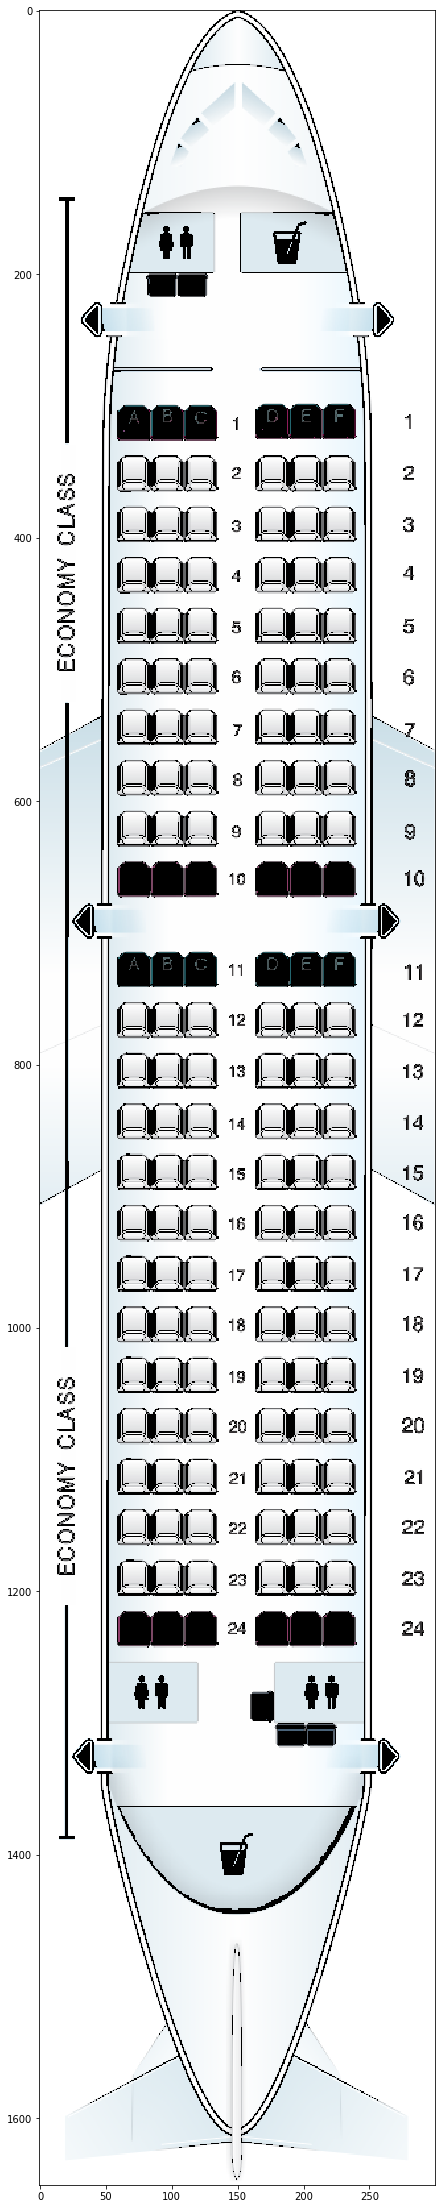

In [91]:
col_obj = Colour(data_path, 'LAYOUT_SEATMAESTRO', 'adria-airways-airbus-a319.png')
img_res = col_obj.colour_pipeline(colours = {}, epsilon = 60, colour_mode = False, 
                    default_colour = [255, 255, 255], rgb_len = 3)
ImageUtil('', '', img_res).visualisation(20, 40)

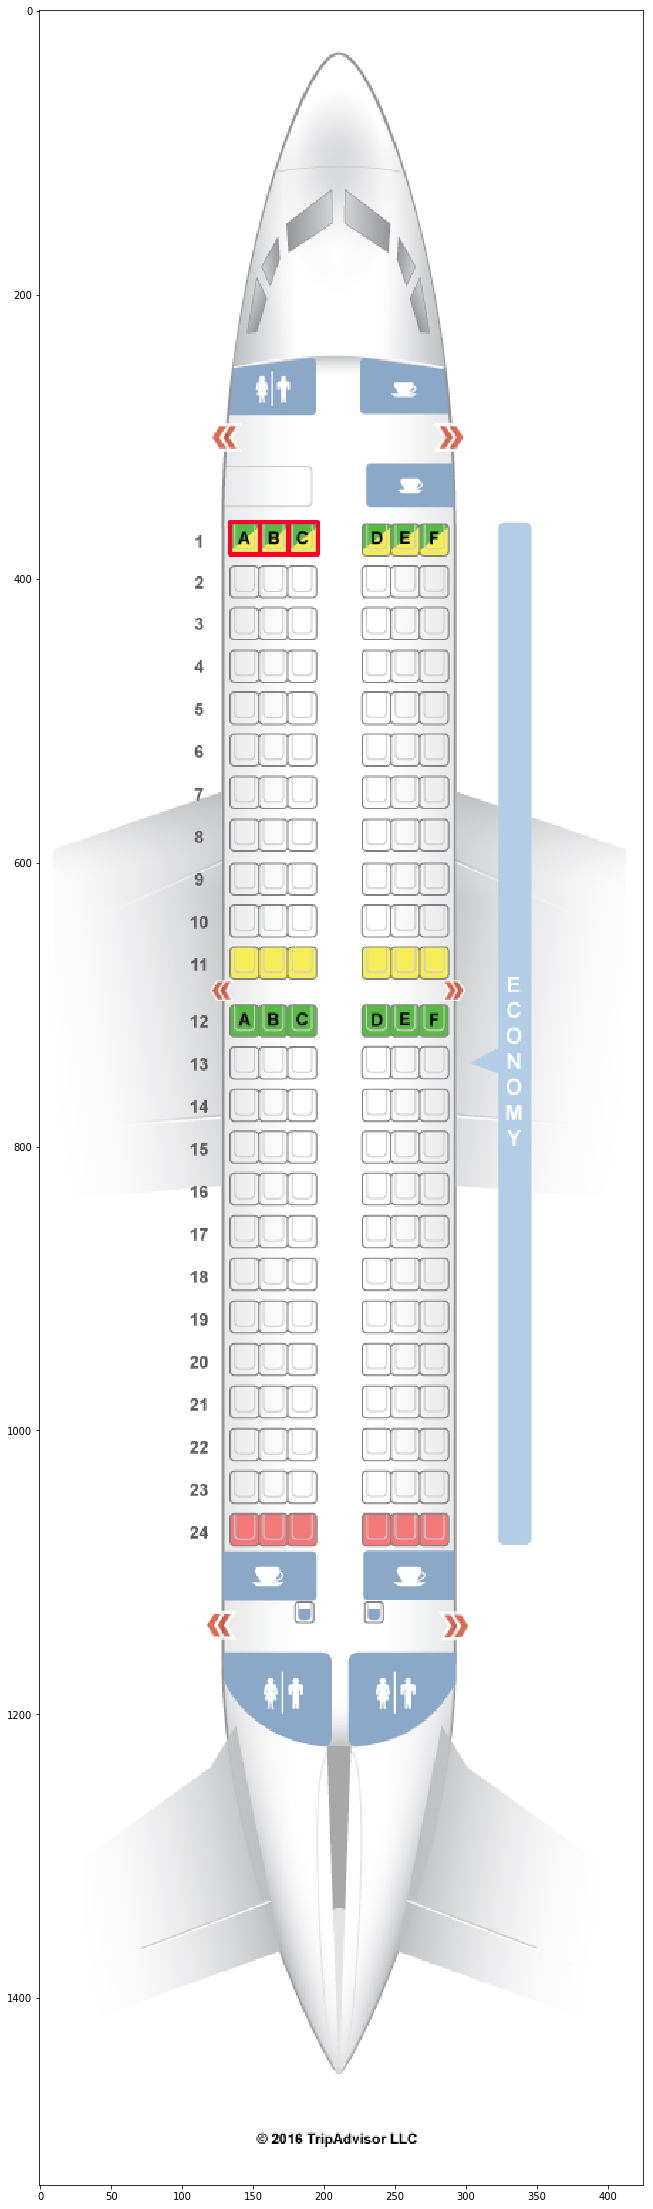

In [53]:
test_img = plt.imread(data_path + 'LAYOUT_SEATGURU/' + 'Air_Serbia_Boeing_737-300_plane121.jpg')

x, y= 134,360
w, h = abs(155-x),abs(383-y)
test_img = cv.rectangle(test_img, (x,y), (x+w, y+h), (255,0, 40), 2)
x, y = 155,360
w, h = abs(175-x),abs(383-y)
test_img = cv.rectangle(test_img, (x,y), (x+w, y+h), (255,0, 40), 2)
x, y = 175,360
w, h = abs(196-x),abs(383-y)
test_img = cv.rectangle(test_img, (x,y), (x+w, y+h), (255,0, 40), 2)

plt.figure(figsize=(20,40))
plt.imshow(test_img)